In [1]:
# Gym stuff
import gymnasium as gym
import torch
import os
import sys
sys.path.append(os.path.abspath("..")) 
import gym_envs

# Stable baselines - rl stuff
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.callbacks import BaseCallback

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import random
import seaborn as sns
import os

dict_keys(['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Acrobot-v1', 'phys2d/CartPole-v0', 'phys2d/CartPole-v1', 'phys2d/Pendulum-v0', 'LunarLander-v2', 'LunarLanderContinuous-v2', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'CarRacing-v2', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'CliffWalking-v0', 'Taxi-v3', 'tabular/Blackjack-v0', 'tabular/CliffWalking-v0', 'Reacher-v2', 'Reacher-v4', 'Pusher-v2', 'Pusher-v4', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'HumanoidStandup-v2', 'HumanoidStandup-v4', 'GymV21Environment-v0', 'GymV26Environment-v0', 'forex-v0', 'stocks-v0', 'zero-stocks-v0', 'alpha-stocks-v0', 'beta-s

In [2]:
apple_df = pd.read_csv('../data/appldata.csv', parse_dates=["Date"], index_col="Date")
gamestop_df = pd.read_csv('../data/gmedata.csv', parse_dates=["Date"], index_col="Date")
google_df = pd.read_csv('../data/googldata.csv', parse_dates=["Date"], index_col="Date")

df = google_df
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-08-23,1219.880005,1235.170044,1219.349976,1221.160034,1221.160034,1233300
2018-08-24,1226.000000,1237.400024,1221.420044,1236.750000,1236.750000,1222700
2018-08-27,1244.140015,1257.869995,1240.680054,1256.270020,1256.270020,1429000
2018-08-28,1255.900024,1256.560059,1242.969971,1245.859985,1245.859985,1366500
2018-08-29,1255.000000,1267.170044,1252.800049,1264.650024,1264.650024,1846300


In [3]:
# Create the environment setup
env = gym.make('beta-stocks-v0', df=df, trade_fee_percent=0.0, capital=10000, window_size=5, frame_bound=(10, 100), render_mode=None)
# It is to be noted that the first element of frame_bound should be greater than or equal to window_size.

capital: 10000
trade_fee_percent: 0.0
buy_hold_end capital: 11990.565318652221
buy_hold_profit: 1990.5653186522213


In [4]:
print("env information:")
print("> shape:", env.unwrapped.shape)
print("> Action space:", env.unwrapped.action_space)
print("> Observation space:", env.unwrapped.observation_space)
print("> df.shape:", env.unwrapped.df.shape)
print("> prices.shape:", env.unwrapped.prices.shape)
print("> signal_features.shape:", env.unwrapped.signal_features.shape)
print("> buy_hold_profit:", env.unwrapped.buy_hold_profit)

env information:
> shape: (5, 2)
> Action space: Discrete(2)
> Observation space: Box(-10000000000.0, 10000000000.0, (5, 2), float32)
> df.shape: (2335, 6)
> prices.shape: (95,)
> signal_features.shape: (95, 2)
> buy_hold_profit: 11990.565318652221


In [5]:
# Print Stats
def print_stats(reward_over_episodes):
    """  Print Reward  """

    avg = np.mean(reward_over_episodes)
    min = np.min(reward_over_episodes)
    max = np.max(reward_over_episodes)

    print (f'Min. Reward          : {min:>10.3f}')
    print (f'Avg. Reward          : {avg:>10.3f}')
    print (f'Max. Reward          : {max:>10.3f}')

    return min, avg, max

# ProgressBarCallback for model.learn()
class ProgressBarCallback(BaseCallback):
    def __init__(self, check_freq: int = 100, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.progress_bar = None

    def _on_training_start(self) -> None:
        """
        Called at the start of training.
        Initializes the progress bar.
        """
        if self.verbose:
            self.progress_bar = tqdm(total=self.model._total_timesteps, desc="Training Progress")

    def _on_step(self) -> bool:
        """
        Updates the progress bar on each step.
        """
        if self.progress_bar is not None:
            self.progress_bar.update(1)
        return True

    def _on_training_end(self) -> None:
        """
        Closes the progress bar at the end of training.
        """
        if self.progress_bar is not None:
            self.progress_bar.close()


class RewardTrackerCallback(BaseCallback):
    def __init__(self):
        super().__init__()
        self.episode_rewards = []
        self.episode_lengths = []
        self.episode_count = 0
        self.total_reward = 0

    def _on_step(self) -> bool:
        # Get rewards from the environment
        rewards = self.locals['rewards']
        self.total_reward += np.sum(rewards)

        # Check if an episode is done
        dones = self.locals['dones']
        for done in dones:
            if done:
                self.episode_rewards.append(self.total_reward)
                self.episode_lengths.append(self.episode_count)
                self.total_reward = 0
                self.episode_count += 1
        
        return True

In [6]:
# Train + Test the environment

seed = 42  # random seed

print ("seed :", seed)

progress_callback = ProgressBarCallback(check_freq=100)
reward_callback = RewardTrackerCallback()

# Train vectorized environment
env_maker = lambda: gym.make('beta-stocks-v0', df=df, trade_fee_percent=0.0, capital=10000, window_size=5, frame_bound=(10, 100))
env = DummyVecEnv([env_maker])

model = PPO('MlpPolicy', env, learning_rate=0.0001, verbose=0)

#model.learn(total_timesteps=10000, callback=ProgressBarCallback(100))
model.learn(total_timesteps=50000, callback=[progress_callback, reward_callback])

# Print episode reward statistics
min_reward, avg_reward, max_reward = print_stats(reward_callback.episode_rewards)

# Define the directory to save the model
save_dir = "../models/"
os.makedirs(save_dir, exist_ok=True)  # Ensure the directory exists

# Find the next version number
version = 1
while os.path.exists(f"{save_dir}model_v{version}.zip"):
    version += 1
    print(f"model_v{version} exists")

# Save the model with the new version number
model.save(f"{save_dir}model_v{version}")
print(f"Saved model_v{version}")

seed : 42
capital: 10000
trade_fee_percent: 0.0
buy_hold_end capital: 11990.565318652221
buy_hold_profit: 1990.5653186522213


Training Progress: 51200it [00:57, 897.28it/s]                            

Min. Reward          :    -38.141
Avg. Reward          :     41.631
Max. Reward          :    107.994
model_v2 exists
model_v3 exists
model_v4 exists
model_v5 exists
model_v6 exists
model_v7 exists
Saved model_v7


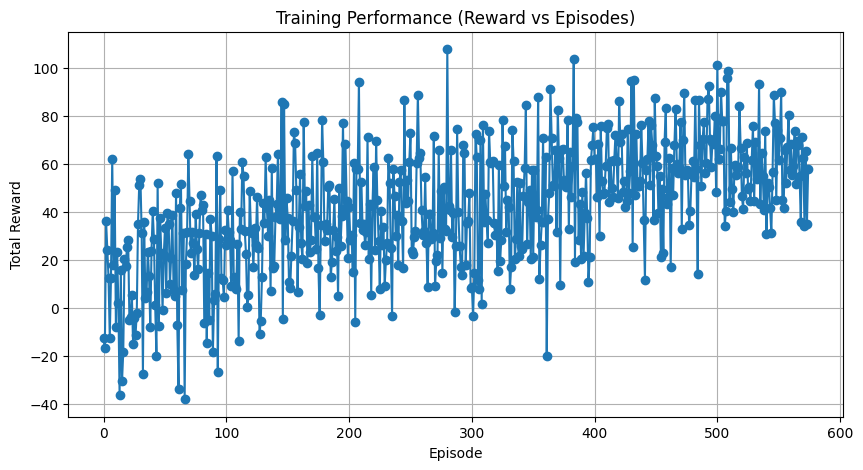

In [7]:
# Plot training rewards
plt.figure(figsize=(10, 5))
plt.plot(reward_callback.episode_lengths, reward_callback.episode_rewards, marker='o', linestyle='-')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Performance (Reward vs Episodes)")
plt.grid()
plt.show()

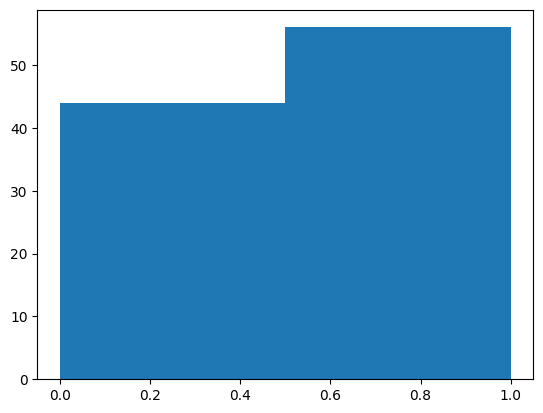

In [8]:
actions = [env.action_space.sample() for _ in range(100)]
plt.hist(actions, bins=2)
plt.show()

capital: 10000
trade_fee_percent: 0.0
buy_hold_end capital: 11990.565318652221
buy_hold_profit: 1990.5653186522213
info: {'total_reward': 70.87595458984377, 'total_profit': 3374.0143248578865, 'position': <Positions.Short: 0>}
Total reward: 70.87595458984377


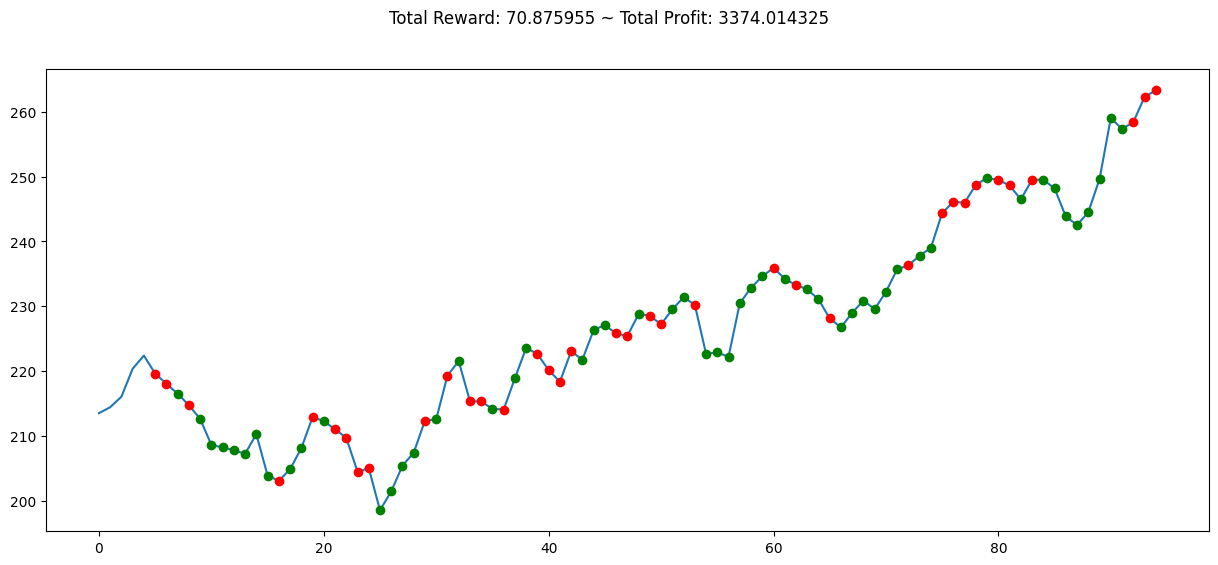

In [10]:
# Initialize the environment
env = gym.make('beta-stocks-v0', df=df, trade_fee_percent=0.0, capital=10000, window_size=5, frame_bound=(10, 100))
model = PPO.load("../models/model_v6")  # Change to your saved model path

# Test the model
observation, info = env.reset()  # Reset the environment

done = False
total_reward = 0

while not done:
    action, _states = model.predict(observation)  # Get action from the model
    observation, reward, terminated, truncated, info = env.step(action)
    total_reward += reward  # Accumulate the reward
    done = terminated or truncated  # Check if episode is done
    
    if done:
        print("info:", info)  # Output additional information when done
        break


print(f"Total reward: {total_reward}")
# Plot the results
plt.figure(figsize=(15, 6))
plt.cla()
# Ensure this method is correctly defined in your environment
env.unwrapped.render_all()  
plt.show()